## TAnoGAN: Time Series Anomaly Detection with Generative Adversarial Networks

Published in: 2020 IEEE Symposium Series on Computational Intelligence (SSCI)

Paper link: https://ieeexplore.ieee.org/abstract/document/9308512

### Import required libraries

In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision
import torch.nn.init as init
from torch.autograd import Variable
import datetime
from nab_dataset import NabDataset
from models.recurrent_models_pyramid import LSTMGenerator, LSTMDiscriminator

In [2]:
# !pip3 install scikit-learn

In [3]:
# !pip3 install pandas

In [4]:
# !pip3 install torch torchvision torchaudio

#### Define Basic Settings for Adversarial Training

In [5]:
class ArgsTrn:
    workers=4
    batch_size=128
    epochs=100
    lr=0.002 #original was 0.0002
    cuda = True
    manualSeed=6
    
opt_trn=ArgsTrn()

In [6]:
torch.manual_seed(opt_trn.manualSeed)
cudnn.benchmark = True

### Setup Data Loader

In [7]:
# location of datasets and category
end_name = 'ambient_temperature_system_failure.csv' # dataset name
data_file = 'data/realKnownCause/'+end_name # dataset category and dataset name
key = 'realKnownCause/'+end_name # This key is used for reading anomaly labels

In [8]:
# settings for data loader
class DataSettings:
    
    def __init__(self):
        self.BASE = '/users/extusr/kaustavprasad/Datasets/NAB/'
        self.label_file = 'labels/combined_windows.json'
        self.data_file = data_file
        self.key = key
        self.train = True
        self.window_length = 60
    
    
data_settings = DataSettings()

In [9]:
# define dataset object and data loader object for NAB dataset
dataset = NabDataset(data_settings=data_settings)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=opt_trn.batch_size,
                                         shuffle=True, num_workers=int(opt_trn.workers))

dataset.x.shape, dataset.y.shape # check the dataset shape

(torch.Size([7207, 60, 1]), torch.Size([7207]))

### Setup Models

In [10]:
device = torch.device("cuda:0" if opt_trn.cuda else "cpu") # select the device
seq_len = dataset.window_length # sequence length is equal to the window length
in_dim = dataset.n_feature # input dimension is same as number of feature

In [11]:
# Create generator and discriminator models
netD = LSTMDiscriminator(in_dim=in_dim, device=device).to(device)
netG = LSTMGenerator(in_dim=in_dim, out_dim=in_dim, device=device).to(device)

In [12]:
print("|Discriminator Architecture|\n", netD)
print("|Generator Architecture|\n", netG)

|Discriminator Architecture|
 LSTMDiscriminator(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=100, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
|Generator Architecture|
 LSTMGenerator(
  (lstm0): LSTM(1, 32, batch_first=True)
  (lstm1): LSTM(32, 64, batch_first=True)
  (lstm2): LSTM(64, 128, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=1, bias=True)
    (1): Tanh()
  )
)


In [13]:
# Setup loss function
criterion = nn.BCELoss().to(device)

In [14]:
# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr=opt_trn.lr)
optimizerG = optim.Adam(netG.parameters(), lr=opt_trn.lr)


## ARIMA Model for Anomaly Detection

This section covers the implementation of the ARIMA model for anomaly detection, similar to the GAN-based approach. We will:
1. Prepare the time series data.
2. Fit an ARIMA model.
3. Use the model's residuals to detect anomalies.


In [17]:
# !pip install statsmodels

In [19]:

# Importing necessary libraries for ARIMA
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Loading the data
data_path = data_settings.BASE + 'data/realKnownCause/ambient_temperature_system_failure.csv'
data = pd.read_csv(data_path)
temperature = data['value'].astype(float)

# Checking stationarity
result = adfuller(temperature.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# If necessary, differencing the data to make it stationary
if result[1] > 0.05:
    temperature = temperature.diff().dropna()


ADF Statistic: -5.517563
p-value: 0.000002


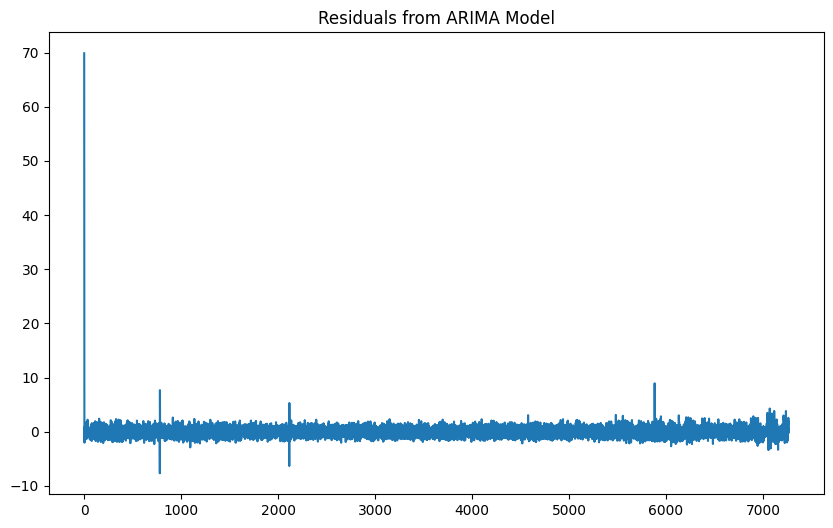

Threshold for anomaly detection: 3.6388476658562383
Detected anomalies: Index([0, 780, 781, 2115, 2116, 5883, 7070, 7116, 7237], dtype='int64')


In [20]:

# Fitting the ARIMA model
model = ARIMA(temperature, order=(1,1,1))
model_fit = model.fit()

# Plotting residuals
residuals = model_fit.resid
plt.figure(figsize=(10,6))
plt.plot(residuals)
plt.title('Residuals from ARIMA Model')
plt.show()

# Anomaly detection based on residuals
threshold = 3 * residuals.std()
print('Threshold for anomaly detection:', threshold)
anomalies = residuals[abs(residuals) > threshold]
print('Detected anomalies:', anomalies.index)


### Adversarial Training of Generator and Discriminator Models

In [21]:
real_label = 1
fake_label = 0

for epoch in range(opt_trn.epochs):
    for i, (x,y) in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################

        #Train with real data
        netD.zero_grad()
        real = x.to(device)
        batch_size, seq_len = real.size(0), real.size(1)
        label = torch.full((batch_size, seq_len, 1), real_label, device=device)

        output,_ = netD.forward(real)
        errD_real = criterion(output, label.float())
        errD_real.backward()
        optimizerD.step()
        D_x = output.mean().item()
        
        #Train with fake data
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        fake,_ = netG.forward(noise)
        output,_ = netD.forward(fake.detach()) # detach causes gradient is no longer being computed or stored to save memeory
        label.fill_(fake_label)
        errD_fake = criterion(output, label.float())
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()
        
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
        fake,_ = netG.forward(noise)
        label.fill_(real_label) 
        output,_ = netD.forward(fake)
        errG = criterion(output, label.float())
        errG.backward()
        optimizerG.step()
        D_G_z2 = output.mean().item()
        
        

    print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
          % (epoch, opt_trn.epochs, i, len(dataloader),
             errD.item(), errG.item(), D_x, D_G_z1, D_G_z2), end='')
    print()

/tmp/ipykernel_2464807/3003258673.py:24: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()
/tmp/ipykernel_2464807/3003258673.py:38: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  noise = Variable(init.normal(torch.Tensor(batch_size,seq_len,in_dim),mean=0,std=0.1)).cuda()


[0/100][56/57] Loss_D: 1.3132 Loss_G: 0.3479 D(x): 0.9080 D(G(z)): 0.6899 / 0.7108
[1/100][56/57] Loss_D: 0.9756 Loss_G: 0.8229 D(x): 0.7238 D(G(z)): 0.4400 / 0.4395
[2/100][56/57] Loss_D: 0.6809 Loss_G: 0.8859 D(x): 0.8991 D(G(z)): 0.4146 / 0.4135
[3/100][56/57] Loss_D: 0.8348 Loss_G: 0.7370 D(x): 0.8507 D(G(z)): 0.4787 / 0.4786
[4/100][56/57] Loss_D: 0.9175 Loss_G: 0.8625 D(x): 0.7363 D(G(z)): 0.4213 / 0.4222
[5/100][56/57] Loss_D: 0.2525 Loss_G: 2.2842 D(x): 0.9436 D(G(z)): 0.1337 / 0.1304
[6/100][56/57] Loss_D: 0.9238 Loss_G: 0.8154 D(x): 0.7499 D(G(z)): 0.4440 / 0.4450
[7/100][56/57] Loss_D: 0.9303 Loss_G: 0.8633 D(x): 0.7462 D(G(z)): 0.4397 / 0.4229
[8/100][56/57] Loss_D: 1.1677 Loss_G: 0.7931 D(x): 0.6205 D(G(z)): 0.4437 / 0.4541
[9/100][56/57] Loss_D: 0.8080 Loss_G: 0.8639 D(x): 0.8223 D(G(z)): 0.4243 / 0.4229
[10/100][56/57] Loss_D: 1.0076 Loss_G: 0.6960 D(x): 0.7804 D(G(z)): 0.5018 / 0.4991
[11/100][56/57] Loss_D: 1.1543 Loss_G: 0.7169 D(x): 0.6600 D(G(z)): 0.4882 / 0.4889
[1

## Anomaly Detection

#### Define basic settings for inverse mapping

In [22]:
class ArgsTest:
    workers = 1
    batch_size = 1
    
opt_test=ArgsTest()    

In [23]:
generator = netG # changing reference variable 
discriminator = netD # changing reference variable 

##### Define Test Data

In [24]:
# Define settings for loading data in evaluation mood
class TestDataSettings:
    
    def __init__(self):
        self.BASE = '/users/extusr/kaustavprasad/Datasets/NAB/'
        self.label_file = 'labels/combined_windows.json'
        self.data_file = data_file
        self.key = key
        self.train = False

        
test_data_settings = TestDataSettings()


In [25]:
# define dataset object and data loader object in evaluation mood for NAB dataset

test_dataset = NabDataset(test_data_settings)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=opt_test.batch_size, 
                                         shuffle=False, num_workers=int(opt_test.workers))

test_dataset.x.shape, test_dataset.y.shape, test_dataset.data_len # check the dataset shape

(torch.Size([121, 60, 1]), torch.Size([121]), 121)

#### Define a function to calculate anomaly score

In [26]:
# Lambda = 0.1 according to paper
# x is new data, G_z is closely regenerated data

def Anomaly_score(x, G_z, Lambda=0.1):
    residual_loss = torch.sum(torch.abs(x-G_z)) # Residual Loss
    
    # x_feature is a rich intermediate feature representation for real data x
    output, x_feature = discriminator(x.to(device)) 
    # G_z_feature is a rich intermediate feature representation for fake data G(z)
    output, G_z_feature = discriminator(G_z.to(device)) 
    
    discrimination_loss = torch.sum(torch.abs(x_feature-G_z_feature)) # Discrimination loss
    
    total_loss = (1-Lambda)*residual_loss.to(device) + Lambda*discrimination_loss
    return total_loss

### Inverse mapping to latent space and reconstruction of data for estimating anomaly score

In [27]:
loss_list = []
#y_list = []
for i, (x,y) in enumerate(test_dataloader):
    print(i, y)
    
    z = Variable(init.normal(torch.zeros(opt_test.batch_size,
                                     test_dataset.window_length, 
                                     test_dataset.n_feature),mean=0,std=0.1),requires_grad=True)
    #z = x
    z_optimizer = torch.optim.Adam([z],lr=1e-2)
    
    loss = None
    for j in range(50): # set your interation range
        gen_fake,_ = generator(z.cuda())
        loss = Anomaly_score(Variable(x).cuda(), gen_fake)
        loss.backward()
        z_optimizer.step()

    loss_list.append(loss) # Store the loss from the final iteration
    #y_list.append(y) # Store the corresponding anomaly label
    print('~~~~~~~~loss={},  y={} ~~~~~~~~~~'.format(loss, y))
    #break

0 tensor([0.])


/tmp/ipykernel_2464807/3365411315.py:6: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  z = Variable(init.normal(torch.zeros(opt_test.batch_size,


~~~~~~~~loss=112.61831665039062,  y=tensor([0.]) ~~~~~~~~~~
1 tensor([0.])
~~~~~~~~loss=34.1494255065918,  y=tensor([0.]) ~~~~~~~~~~
2 tensor([0.])
~~~~~~~~loss=38.48020935058594,  y=tensor([0.]) ~~~~~~~~~~
3 tensor([0.])
~~~~~~~~loss=392.9874267578125,  y=tensor([0.]) ~~~~~~~~~~
4 tensor([0.])
~~~~~~~~loss=36.378082275390625,  y=tensor([0.]) ~~~~~~~~~~
5 tensor([0.])
~~~~~~~~loss=440.50006103515625,  y=tensor([0.]) ~~~~~~~~~~
6 tensor([0.])
~~~~~~~~loss=432.8793029785156,  y=tensor([0.]) ~~~~~~~~~~
7 tensor([0.])
~~~~~~~~loss=44.05691909790039,  y=tensor([0.]) ~~~~~~~~~~
8 tensor([0.])
~~~~~~~~loss=80.30516815185547,  y=tensor([0.]) ~~~~~~~~~~
9 tensor([0.])
~~~~~~~~loss=467.5834045410156,  y=tensor([0.]) ~~~~~~~~~~
10 tensor([0.])
~~~~~~~~loss=482.5965576171875,  y=tensor([0.]) ~~~~~~~~~~
11 tensor([0.])
~~~~~~~~loss=463.78955078125,  y=tensor([0.]) ~~~~~~~~~~
12 tensor([0.])
~~~~~~~~loss=45.06005859375,  y=tensor([0.]) ~~~~~~~~~~
13 tensor([0.])
~~~~~~~~loss=88.43672180175781,  y=te

### Visualise Anomaly Detection

In [28]:
# !pip3 install matplotlib

In [39]:
len(loss_list)

121

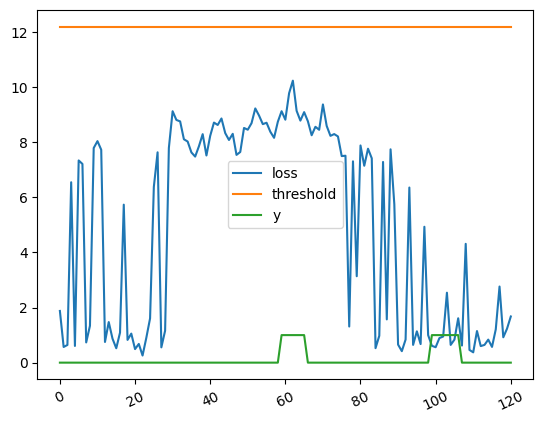

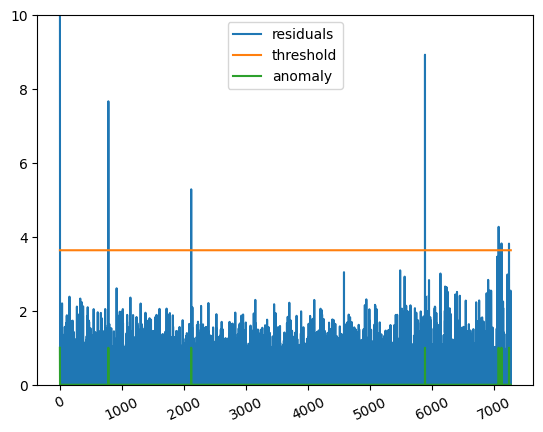

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

THRESHOLD = 12.2 # Anomaly score threshold for an instance to be considered as anomaly 

#TIME_STEPS = dataset.window_length
test_score_df = pd.DataFrame(index=range(test_dataset.data_len))
test_score_df['loss'] = [loss.item()/test_dataset.window_length for loss in loss_list]
test_score_df['y'] = test_dataset.y
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['t'] = [x[59].item() for x in test_dataset.x]

plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.plot(test_score_df.index, test_score_df.y, label='y')
plt.xticks(rotation=25)
plt.legend()
plt.show()

#Do the same for the ARIMA model fitted earlier
arima_score_df = pd.DataFrame(index=range(len(temperature)))
arima_score_df['residuals'] = residuals
arima_score_df['threshold'] = threshold
arima_score_df['anomaly'] = abs(arima_score_df.residuals) > threshold
arima_score_df['t'] = temperature[1:]

plt.plot(arima_score_df.index, arima_score_df.residuals, label='residuals')
plt.plot(arima_score_df.index, arima_score_df.threshold, label='threshold')
plt.plot(arima_score_df.index, arima_score_df.anomaly, label='anomaly')
plt.xticks(rotation=25)
plt.legend()
plt.ylim(0, 10)
# plt.yscale('log')
plt.show()



In [42]:
# !pip3 install seaborn

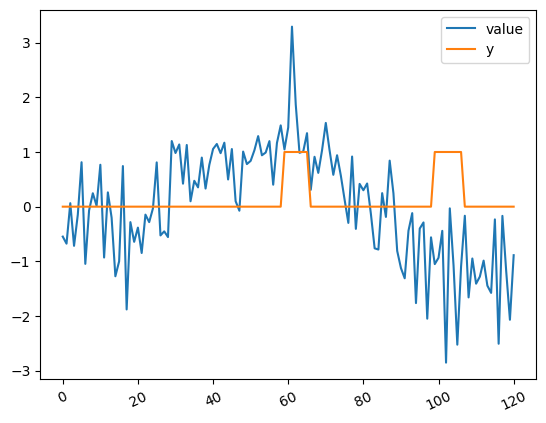

In [31]:
import seaborn as sns

anomalies = test_score_df[test_score_df.anomaly == True]

plt.plot(
  range(test_dataset.data_len), 
  test_score_df['t'], 
  label='value'
);
# ORIGINAL
# sns.scatterplot(
#   anomalies.index,
#   anomalies.t,
#   color=sns.color_palette()[3],
#   s=52,
#   label='anomaly'
# )

sns.scatterplot(
  x=anomalies.index,
  y=anomalies.t,
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)

plt.plot(
  range(len(test_score_df['y'])),
  test_score_df['y'],
  label='y'
)

plt.xticks(rotation=25)
plt.legend();

### Calculate the window-based anomalies

In [32]:
import numpy as np
start_end = []
state = 0
for idx in test_score_df.index:
    if state==0 and test_score_df.loc[idx, 'y']==1:
        state=1
        start = idx
    if state==1 and test_score_df.loc[idx, 'y']==0:
        state = 0
        end = idx
        start_end.append((start, end))

for s_e in start_end:
    if sum(test_score_df[s_e[0]:s_e[1]+1]['anomaly'])>0:
        for i in range(s_e[0], s_e[1]+1):
            test_score_df.loc[i, 'anomaly'] = 1
            
actual = np.array(test_score_df['y'])
predicted = np.array([int(a) for a in test_score_df['anomaly']])

### Calculate measurement scores

In [33]:
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_curve, auc, roc_auc_score

predicted = np.array(predicted)
actual = np.array(actual)

tp = np.count_nonzero(predicted * actual)
tn = np.count_nonzero((predicted - 1) * (actual - 1))
fp = np.count_nonzero(predicted * (actual - 1))
fn = np.count_nonzero((predicted - 1) * actual)

print('True Positive\t', tp)
print('True Negative\t', tn)
print('False Positive\t', fp)
print('False Negative\t', fn)

accuracy = (tp + tn) / (tp + fp + fn + tn + 1e-9)
precision = tp / (tp + fp + 1e-9)
recall = tp / (tp + fn + 1e-9)
fmeasure = (2 * precision * recall) / (precision + recall + 1e-9)
cohen_kappa_score = cohen_kappa_score(predicted, actual)
false_positive_rate, true_positive_rate, thresholds = roc_curve(actual, predicted)
auc_val = auc(false_positive_rate, true_positive_rate)
roc_auc_val = roc_auc_score(actual, predicted)

print('Accuracy\t', accuracy)
print('Precision\t', precision)
print('Recall\t', recall)
print('f-measure\t', fmeasure)
print('cohen_kappa_score\t', cohen_kappa_score)
print('auc\t', auc_val)
print('roc_auc\t', roc_auc_val)

#Compute the metrics for ARIMA

print("ARIMA Model")
actual = np.array(arima_score_df['anomaly'])


True Positive	 0
True Negative	 106
False Positive	 0
False Negative	 15
Accuracy	 0.8760330578439997
Precision	 0.0
Recall	 0.0
f-measure	 0.0
cohen_kappa_score	 0.0
auc	 0.5
roc_auc	 0.5


In [34]:
# import winsound
# frequency = 200  # Set Frequency To 2500 Hertz
# duration = 2000  # Set Duration To 1000 ms == 1 second
# winsound.Beep(frequency, duration)